# CSE 152A Fall 2022 – Assignment 4Fri

Assignment Published On: **Fri, Nov 18, 2022**

Due On: **Thur, Dec 1, 2022 11:59 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file. 

## Instructions for Google Colab
You will be running this homework on google colab which provides free GPU resources which we can use for accelerating deep learning. Google colab is an online jupyter notebook which can run code on GPU. 

To get started:

- Navigate to https://colab.research.google.com
If asked for login, sign in with any google account (your ucsd id works too).
- Upload the HW4.ipynb to colab. You can do this by `File -> upload notebook`
- Go to `Runtime -> Change run time type -> Select GPU from the dropdown`
- Connect to the instance
- All required packages are already installed in the environment. In case you would like to install a package you can simply run `!pip install <package-name>`.


### Note:
Since you will be using the free tier, you can run a notebook for a maximum of 12hrs at a stretch after which you need to reload the notebook. 
We suggest you switch to GPU instance when you need to train or test the model and use the CPU instance for running non-mathematical operations. You can switch instances between the CPU and GPU anytime using the `Runtime` menu without loss of work.

In the rare chance you don't get a GPU instance try again in 15mins and use the CPU instance until then.

# Theory Problem

## 1. Backpropogation

Please refer to "q1.png" for questions and write your answer below.

## 1. (a)

attached


## 1. (b)

attached

## 1. (c)

attached

## 1. (d)

attached

# Programming Problem

**You need to have an enviroment with CUDA GPU to finish this homework**. If you don't have access to such environment, a good platform to look at is Google Colab, which provides a free CUDA GPU server.

**You also need to download MNIST and CIFAR-10 dataset to accomplish this homework.** The following cell is given to help you download them. It requires certain tool to be installed in your environment. You can either use this cell to download the datasets or manually download them on the corresponding websites.

In [15]:
# Get necessary datasets; this cell only needs to be run once
!if [ -e "MNIST" ];then rm -rf "MNIST" ; fi
!if [ -e "CIFAR-10" ];then rm -rf "CIFAR-10" ; fi

!mkdir MNIST
%cd MNIST
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz
%cd ..

!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..

/content/MNIST
--2022-12-07 02:57:52--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2022-12-07 02:57:53 (93.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2022-12-07 02:57:53--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 1

## 2. Training a small CNN for MNIST digit classification

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import struct
from torch.utils.data import Dataset
import random
import os
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# import os
# os.chdir("/Users/zhizhenyu/Desktop/CSE 152A/HW4")
# !ls

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-17-fafec4634ca8>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset is "training":
<ipython-input-17-fafec4634ca8>:15: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif dataset is "testing":


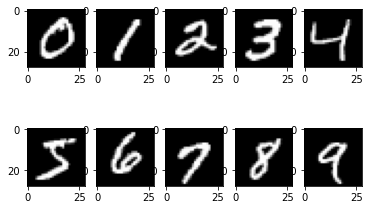

In [17]:
# DATA PARSING
# You can manually download the data from http://yann.lecun.com/exdb/mnist/ and set path
path = "./MNIST/"

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
torchTrainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
torchTestData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))
# print(torchTestData)

plt.figure()
for i in range(10):
    ind=np.where(trainLabels==i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[ind][:,:,0],cmap='gray')
plt.show()

**[ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2  

* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2   

* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [18]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        
        # YOUR CODE HERE
        # DEFINE THE NETWORK STRUCTURE
        
        #fix. - dropout
        #between the 1st and 2nd fully connected layer 
        if (drop == True):
          self.dropout = nn.Dropout(p=0.4)
        elif (drop == False):
          self.dropout = None

        self.conv1 = nn.Conv2d(1, 32, 5,stride=1,padding=2,bias=True)
        #1x28x28 -> 32x28x28
        self.conv2 = nn.Conv2d(32, 64, 5, stride=1,padding=2,bias=True)
        
        self.fc1 = nn.Linear(3136, 1024) 
        self.fc2 = nn.Linear(1024, 10)
        # You can look at https://github.com/ameykusurkar/pytorch-image-classifier/blob/master/main.py for reference
        
    def forward(self, x):
        
        # YOUR CODE HERE
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,stride=2)
        x = F.relu(self.conv2(x))
        
        x = F.max_pool2d(x,2,stride=2)
        x = x.reshape(-1, 3136)

        x = self.fc1(x)
        x = F.relu(x)
        # x = F.dropout2d(x, 0.4)

        if(self.dropout==True):
          x = self.dropout(x)
        x = self.fc2(x)
        
        
        return x

# Print net
net = Net(drop=True)
print(net)

Net(
  (dropout): Dropout(p=0.4, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


**[ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**
* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on training set on the same plot
* Print the accuracy on test set

Test accuracies are expected to be quite high (~98 %)

In [19]:
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# import tensorflow as tf
# to_train is a parameter that determines what part of the net to train
# it is not required for this question, but will be useful in the next one
def train(tdata,tlabel,net,to_train,opt, batch):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    # Change parameters as required
    epochs=15
    # batch=200
    learning_rate=1e-3
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
      
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            # YOUR CODE HERE
            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losslist.append(loss)
            
            prediction = net(inputs)
            acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds])
            acclist.append(acc)  

    return losslist,acclist

def test(tdata,tlabel,net):
    inputs = Variable(torch.FloatTensor(tdata).cuda())
    targets = Variable(torch.LongTensor(tlabel).cuda())
    prediction = net(inputs)
    acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel)
    return acc

100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


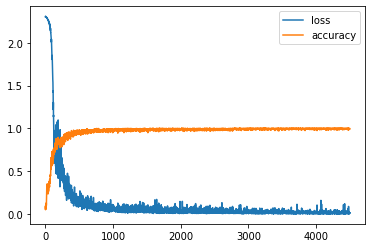

Accuracy:0.9897


100%|██████████| 15/15 [00:44<00:00,  2.95s/it]


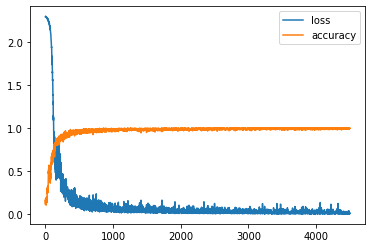

Accuracy:0.9908


100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


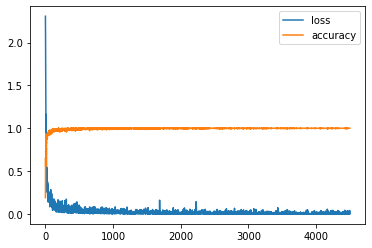

Accuracy:0.9915


100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


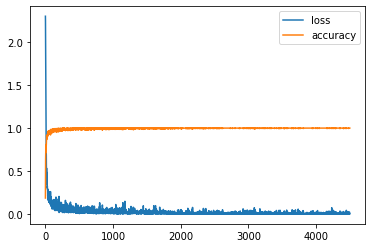

Accuracy:0.9936


In [20]:
# Example code 
batch=200
net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',batch)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',batch)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))
# YOUR CODE HERE

**[ 5 points ] Plot the following graphs and comment on them**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot 
* Training loss graphs for Adam-dropout for 3 different values of batch size such that there is some difference in the graphs, on the same plot

100%|██████████| 15/15 [00:44<00:00,  2.94s/it]


Accuracy-sgd dropout:0.9912


100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


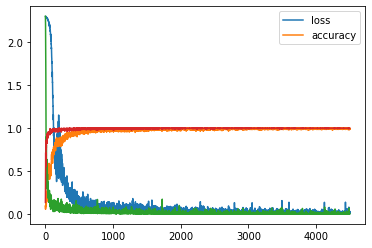

Accuracy-adam dropout:0.9923
Comments: The accuracy is very similar.


100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


batchsize: 200
Accuracy:0.9911


100%|██████████| 15/15 [00:38<00:00,  2.58s/it]


batchsize: 700
Accuracy:0.9922


100%|██████████| 15/15 [00:37<00:00,  2.52s/it]


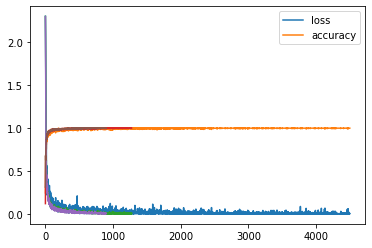

batchsize: 1000
Accuracy:0.9911
Comments: The accuracy is very similar.


In [21]:
# YOUR CODE HERE
batch1 = 200
batch2 = 700
batch3 = 1000

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',batch1)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print('Accuracy-sgd dropout:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch1)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy-adam dropout:{}'.format(test(torchTestData,testLabels,net)))
print("Comments: The accuracy is very similar.")

# second

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch1)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print("batchsize:", batch1)
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch2)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print("batchsize:", batch2)
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',batch3)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print("batchsize:", batch3)
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))
print("Comments: The accuracy is very similar. However, the larger the batchsize, the smaller the accuracy.")




**[ 2 points ] Plot the training loss graphs for changes made in any particular parameter (learning rate/momentum etc) such that there is a clear difference in the graphs, on the same plot, and comment.**

100%|██████████| 15/15 [00:43<00:00,  2.88s/it]


Accuracy for learning_rate1:0.101


100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


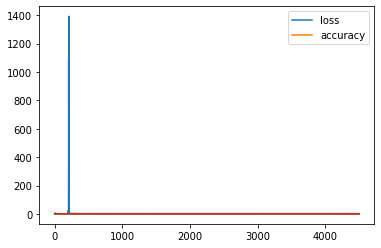

Accuracy for learning_rate2:0.9905
Comments: From this comparison, changing little bit of learning rate leads to significant change in accuracy.


In [14]:
# YOUR CODE HERE
def train(tdata,tlabel,net,to_train,opt, learning_rate):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]

    
    # Change parameters as required
    epochs=15
    batch=200
    
    
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
        
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            # YOUR CODE HERE
            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losslist.append(loss)
            
            prediction = net(inputs)
            acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds])
            acclist.append(acc)
            

    return losslist,acclist
# print(losstrained)

learning_rate1=1e-1
learning_rate2=1e-3

net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',learning_rate1)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print('Accuracy for learning_rate1:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',learning_rate2)
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()

print('Accuracy for learning_rate2:{}'.format(test(torchTestData,testLabels,net)))
print("Comments: From this comparison, changing little bit of learning rate leads to significant change in accuracy.")

In [22]:
###############################  QUESTION 3  ##############################################

## 3. Transfer learning

You will now visualize the effects of transfer learning by performing experiments using the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks

In [23]:
# DATA PARSING
# You can manually download the data from from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and set path
path='./CIFAR-10/cifar-10-batches-py/'
data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)
# for ele in labels:
#   print(ele)
# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9

 **[ 2 points ] Plot 3 random images corresponding to each label from the training data**


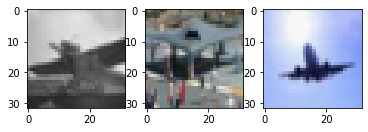

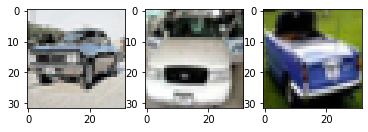

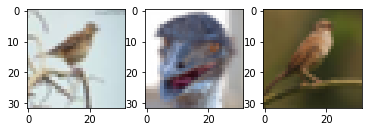

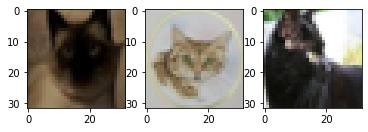

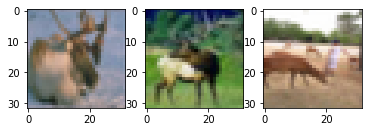

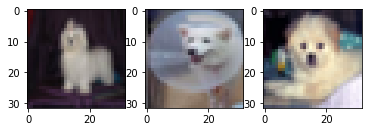

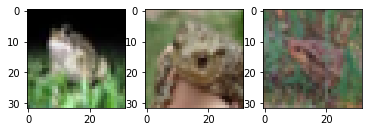

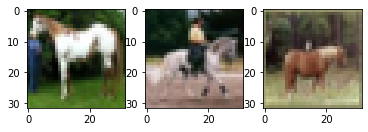

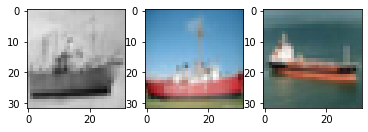

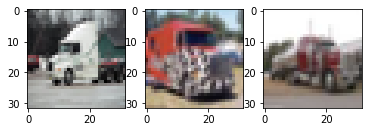

In [24]:
# YOUR CODE HERE #
for i in range(10):
  labelsSub = []
  for k in range(len(labels)):
    if labels[k] == i:
      labelsSub.append(k)
  rand = np.random.choice(labelsSub, size=3,replace=False)
  fig = plt.figure()
  rows = 1
  columns = 3
  j =0
  for ele1 in rand:
    fig.add_subplot(rows, columns,j+1)
    if (j == 2):
      j = 0
    else:
      j+=1
    plt.imshow(data[ele1])


In [25]:
# Split the data and labels into 2 sets, first one containing labels 0 to 4, and second one from 5 to 9. 

data1=np.zeros((0,32,32,3))
labels1=[]
data2=np.zeros((0,32,32,3))
labels2=[]
for i in range(5):
    x=data[labels==i]
    data1=np.vstack((data1,x))
    labels1+=[i]*len(x)
for i in range(5,10):
    x=data[labels==i]
    data2=np.vstack((data2,x))
    labels2+=[i-5]*len(x)
    
labels1=np.array(labels1)
labels2=np.array(labels2)

torch_data1=data1.transpose((0,3,1,2))
torch_data2=data2.transpose((0,3,1,2))

# testData=np.array(list(read('testing','images')))
# testData=np.float32(np.expand_dims(testData,-1))/255
# torchTestData=testData.transpose((0,3,1,2))
# testLabels=np.int32(np.array(list(read('testing','labels'))))

**[ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**
1. Layer 1 - Kernel size 4, Stride 2, Output channels 5, Bias enabled, Relu activation
2. Layer 2 - Kernel size 4, Stride 1, Output channels 10, Bias enabled, Relu avtication
3. Layer 3 - Kernel size 4, Stride 1, Output channels 20, Bias enabled, Relu activation
4. Layer 4 - Kernel size 4, Stride 1, Output channels 40, Bias enabled, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 5, 4,stride=2,bias=True)
        self.conv2 = nn.Conv2d(5, 10, 4, stride=1,bias=True) 
        self.conv3 = nn.Conv2d(10, 20, 4, stride=1,bias=True)
        self.conv4 = nn.Conv2d(20, 40, 4, stride=1,bias=True)
        self.fc = nn.Linear(1440, 5) #input = (40+2*2-1)/1+1 
        
    def forward(self, x):
        # YOUR CODE HERE
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.reshape(-1,1440)
        x = self.fc(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=1440, out_features=5, bias=True)
)


**[ 5 points ] Complete the train function below and follow the instructions** 

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 60 %.

In [33]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    # Change as required
    epochs=5
    batch=80 
    # changing batch size from 100 to 80
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            # YOUR CODE HERE
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losslist.append(loss)
            
            prediction = net(inputs)
            acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel[inds])
            acclist.append(acc)
    return losslist,acclist

100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


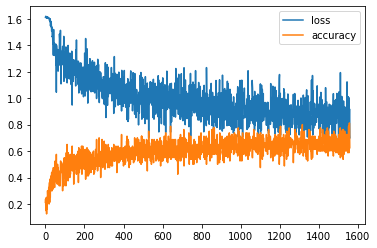

Accuracy:0.625


In [34]:
# YOUR CODE HERE #
net = Net().cuda()
loss,acc = train(torch_data1, labels1, net, net.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))

**[ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)** 

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


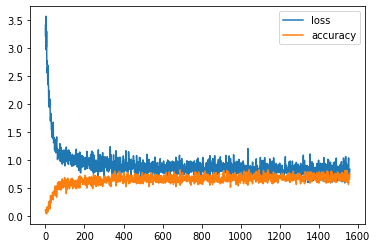

Accuracy:0.762499988079071


In [35]:
# YOUR CODE HERE #
loss,acc = train(torch_data2, labels2, net, net.fc.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))

**[ 3 points ] Now repeat the process in the opposite order** 

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


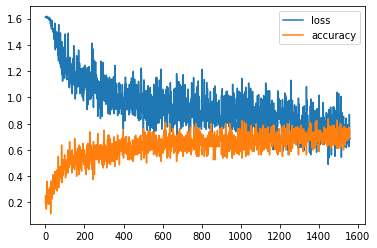

Accuracy:0.75


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


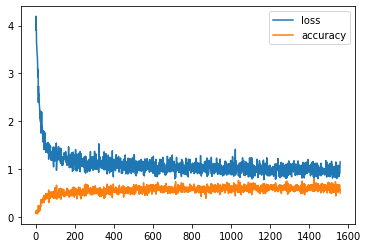

Accuracy:0.5
train data2 -> data1, accuracy higher for data 2 and lower for data 1.


In [37]:
# YOUR CODE HERE #
net = Net().cuda()
loss,acc = train(torch_data2, labels2, net, net.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))
loss,acc = train(torch_data1, labels1, net, net.fc.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))
print("train data2 -> data1, accuracy higher for data 2 and lower for data 1.")

**[ 5 points ]**

* Plot the loss vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Accuracy:0.6625000238418579


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


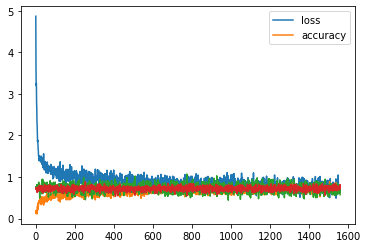

Accuracy:0.8125
normal learning has higher accuracy than transfer learning for data 2 but not for data 1.


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Accuracy:0.7875000238418579


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


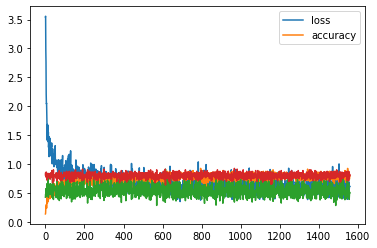

Accuracy:0.800000011920929
Comments: The transfer learning did work because the accuracy is close to the normal learning. It used the trained model to adjust to the new datasets.


In [39]:
# YOUR CODE HERE #
# net = Net().cuda()
loss,acc = train(torch_data1, labels1, net, net.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print('Accuracy:{}'.format(acc[-1]))
loss,acc = train(torch_data1, labels1, net, net.fc.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))
print("normal learning has higher accuracy than transfer learning for data 2 but not for data 1.")

# net = Net().cuda()
loss,acc = train(torch_data2, labels2, net, net.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
print('Accuracy:{}'.format(acc[-1]))
loss,acc = train(torch_data2, labels2, net, net.fc.parameters())
ax=range(len(loss))
loss = torch.Tensor(loss)
acc = torch.Tensor(acc)
plt.plot(ax,loss.cpu().numpy(),ax,acc.cpu().numpy())
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[-1]))
print("Comments: The transfer learning did work because the accuracy is close to the normal learning. It used the trained model to adjust to the new datasets.")

Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this.

In [31]:
Skipped.